## A Machine Learning Model for Prediction of US Residential Electrical Energy Consumption

### Author: Arash Shamseddini

##### In this script I will be using ML techniques to model the electricity consumprion in US residential dwellings. The data is taken from the 2009 RESIDENTIAL ENERGY CONSUMPTION SURVEY (RECS) [here](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata) and is also available in the data folder of this repository. In its 2009 version, data were collected from 12,083 households and represent 113.6 million US households. 

#### Let's get down to business 🚀

----------------------------------------------------------------------------

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy import stats

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import RFE, RFECV

### 1- The Data

In [2]:
# Reading the data in (Make sure the data set is sitting in the same directory as this notebook)
df = pd.read_csv("data/recs2009_public.csv", low_memory=False) # dtype not detected for col. 717 ("NOCRCASH") & col. 718 ("NKRGALNC") so set
                                                               # low_memory=False to avoid mixed type as suggested by Pandas

original_df = df.copy() # A copy for later use

df

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


##### WOW! 940 columns
##### and 12083 observations.

This data set (`2009 RECS Survey Data`) is the 2009 version of a series of data sets from the archive of RESIDENTIAL ENERGY CONSUMPTION SURVEY (RECS).

An overview of the data set from the US Energy Information Adminstration website can be found [here](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata).

The response variable in this data set is the "Total Site Electricity Usage" designated as `"KWH"` (Kilowatt-hours).

Let's take a look at the distribution of `"KWH"`.

<AxesSubplot:>

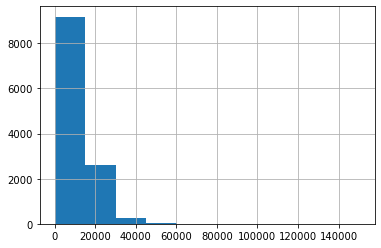

In [3]:
# Histogram for the distribution of KWH as the response
target = "KWH"
df[target].hist(bins=10)

We can see that the response is pretty much right-skewd and the values are mostly concentrated in the `< 20000 KWH` range.

### 2- EDA

Let's check Pandas profiling report to get some insights from the data and most importantly the distribution of variables.

In [4]:
# Calling a short version of Pandas profiling report. This is mainly to see the distribution of predictors and the response ("KWH").
#profile = ProfileReport(df,minimal=True)
#profile

According to the Pandas profiling report some columns have just a few unique values. Let's check the number of unique  values in the columns of the data set.

In [5]:
# Number of unique values in each column of the data set
unique_vals = pd.DataFrame(data=df.nunique(),  columns=["unique_values"])
unique_vals.tail(10)

,unique_values
SCALEKER,3
IECC_Climate_Pub,11
HDD50,4004
CDD80,1026
GND_HDD65,6152
WSF,50
OA_LAT,35
GWT,53
DesignDBT99,90
DesignDBT1,53


As an example, let's check `"SCALEKER"`, which shows: `Whether annualized kerosene consumption from Energy Supplier Survey billing data was scaled down`.

In [6]:
df["SCALEKER"].unique()

array([-2,  3,  0], dtype=int64)

Let's see if there is any NaN values in the data set.

In [7]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : ", df.isnull().sum().sum())

 
Count total NaN in a DataFrame :  0


Let's check the `dtype` of the columns in the data set and the list of columns in each `dtype`.

In [8]:
# Data set columns dtypes
print(" \nDtype of columns in the DataFrame : ", df.dtypes.unique())
print(" \nColumns with dtype:'int64' : ", list(df.select_dtypes(['int64']).columns))
print(" \nColumns with dtype:'float64' : ", list(df.select_dtypes(['float64']).columns))
print(" \nColumns with dtype:'O' : ", list(df.select_dtypes(['O']).columns))

 
Dtype of columns in the DataFrame :  [dtype('int64') dtype('float64') dtype('O')]
 
Columns with dtype:'int64' :  ['DOEID', 'REGIONC', 'DIVISION', 'REPORTABLE_DOMAIN', 'TYPEHUQ', 'HDD65', 'CDD65', 'HDD30YR', 'CDD30YR', 'Climate_Region_Pub', 'AIA_Zone', 'KOWNRENT', 'CONDCOOP', 'YEARMADE', 'YEARMADERANGE', 'OCCUPYYRANGE', 'CONVERSION', 'ORIG1FAM', 'LOOKLIKE', 'NUMFLRS', 'NUMAPTS', 'WALLTYPE', 'ROOFTYPE', 'STUDIO', 'NAPTFLRS', 'STORIES', 'TYPEHUQ4', 'BEDROOMS', 'NCOMBATH', 'NHAFBATH', 'OTHROOMS', 'TOTROOMS', 'CELLAR', 'CRAWL', 'CONCRETE', 'BASEFIN', 'FINBASERMS', 'BASEHEAT', 'BASEHT2', 'PCTBSTHT', 'BASECOOL', 'BASECL2', 'PCTBSTCL', 'BASEUSE', 'ATTIC', 'ATTICFIN', 'FINATTRMS', 'ATTCHEAT', 'ATTCHT2', 'PCTATTHT', 'ATTCCOOL', 'ATTCCL2', 'PCTATTCL', 'ATTICUSE', 'PRKGPLC1', 'SIZEOFGARAGE', 'GARGLOC', 'GARGHEAT', 'GARGCOOL', 'PRKGPLC2', 'SIZEOFDETACH', 'OUTLET', 'ZKOWNRENT', 'ZCONDCOOP', 'ZYEARMADE', 'ZYEARMADERANGE', 'ZOCCUPYYRANGE', 'ZCONVERSION', 'ZORIG1FAM', 'ZLOOKLIKE', 'ZNUMFLRS', 'ZNUMA

**Note:** There are:
- 885 columns with dtype:`int64`
- 35 columns with dtype:`float64`
- 5 columns with dtype:`O` which is equivalent to string

Since this a hugely wide data set, I cannot easlity plot the correlation matrix for all the variables. However, let's check the `Pearson` correlations between the response (`"KWH"`) and independent variables.

Text(0.5, 1.0, 'Distribution of Pearson correlation between response and independent variables')

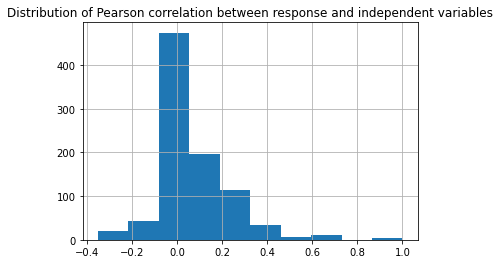

In [9]:
# Pearson correlation between KWH and other variables
df[df.columns[:]].corr()['KWH'][:]

# Let's plot the distribution of the correlation values
pd.DataFrame(df[df.columns[1:]].corr()['KWH'][:].values.tolist()).hist(bins=10)
plt.title('Distribution of Pearson correlation between response and independent variables')

**Note:** Based on above plot a lot of columns have almost zero correlation with the response and this is a good start for removing them.

#### 2-1 Initial Observations

- We have 940 columns and many of these columns are redundant and can be removed from the data set. This removal process is included in the `Feature Engineering` section down below.
> For example, the column `"SCALEKER"` which has three distinct values "[-2,  3,  0]".
- The data set has no missing values which is good news. This could be due to the fact that some columns have already been imputed while finalizing the data set.
- The response and many other independent variables are not normally distributed. 
- The `Pearson` correlation between the response and independent variables are significantly varied. If a Linear Regression model like `Ridge()` is used, the dependent and independent variables should be linearly related. Another assumtion is that there should be less or no `multicollinearity` in the given dataset. I will use these assumptions to remove independent variables.

## 3- Feature Engineering

In this section, I will make an attempt to remove redundant columns. To do so, first I will take a better look at the `Pearson` correlation between the response (`"KWH"`) and the independent variables.

Below, I am returning a data frame of the `Pearson` correlation values between the response and independent variables where the absolute value of the correlation exceeds a pre-determined limit (here, looking at the above histogram for distribution of correlations, I assume `limit=0.5` a.k.a: high correlation values).

In [10]:
# Pearson correlation between KWH and other variables where the abs values exceeds the limit = 0.5
corr_df = pd.DataFrame(df[df.columns[:]].corr()['KWH'][:])
corr_df = corr_df.rename(columns={'KWH': 'correlation'})
high_corr_df = corr_df.query("correlation >= 0.5 | correlation <= -0.5")      
high_corr_df

,correlation
KWH,1.000000
KWHCOL,0.655104
KWHWTH,0.585656
KWHRFG,0.638621
KWHOTH,0.880403
BTUEL,1.000000
BTUELCOL,0.655104
BTUELWTH,0.585656
BTUELRFG,0.638621
BTUELOTH,0.880403


**Note:** Looks like there are quite a few variables known as **highly correlated** with the response (`"KWH"`).

#### 3-1 Removing Redundant Columns

There are quite a few columns in the data set that are **redundant** for different reasons and can be safely removed to make the modeling part more efficient.

But before starting to remove redundant columns in this section, I will remove the target column `"KWH"` as below and add it back to the data set at the end.

In [11]:
# Making copies for later use
df_copy = df.copy() # I will make use of the copy later on
KWH_df = df_copy[['KWH']]

# Dropping target: KWH, I will add it back once I am finishied with removing redundant columns
df.drop(columns = ['KWH'], inplace=True)

**Note:** The variable `"BTUEL"` has a correlation value of 1 with `"KWH"`. Looking at the data set variable dictionary, I can see that `"BTUEL"` represents `Total Site Electricity usage, in thousand BTU` which is technically a different system of units for electrical energy consumption (**BTU stands for British Thermal Unit**).

This means it is safe to drop this column.

In [12]:
# Dropping 'BTUEL' column
df.drop(columns=["BTUEL"], inplace=True)

**Note:** The `"DOEID"` column is a unique id for each respondent and can also be safely removed.

In [13]:
# Dropping 'DOEID' column
df.drop(columns=["DOEID"], inplace=True)

**Note:** Some columns such as `"KWHSPH"` which represents `Electricity usage for space heating` or `"KWHCOL"` which represents `Electricity usage for air-conditioning, central and window/wall (room)` are in fact segregated forms of a main column. So, I will be removing these columns. Same story goes with the **BTU** side (e.g. `"BTUELSPH"` or `"BTUELCOL"`).

In [14]:
# Returning segregated columns
segregated_cols = [col for col in df.columns if (("KWH" in col and len(col) > 3) or "BTUEL" in col)]

In [15]:
# Dropping segregated columns
df.drop(columns = segregated_cols, inplace=True)

**Note:** There are also columns known as "Imputation flag columns" (without exception starting with letter "Z") that I should also consider removing. They do not seem to provide any valuable information. The values in these columns are mostly `0`.

Before dropping these columns let's see if they are part of highly correlated columns. To do this, I will make use of below helper function.

In [16]:
# Helper function
def list_contains(List1, List2): 
  
    set1 = set(List1) 
    set2 = set(List2) 
    if set1.intersection(set2): 
        return True 
    else: 
        return False

In [17]:
# Returning imputed columns
imputed_cols = [col for col in df.columns if col.startswith("Z")]

In [18]:
# Checking if any of the imputed columns are highly correlated with the response
list_contains(imputed_cols, high_corr_df.index.tolist())

False

So it is safe to drop these columns.

In [19]:
# Dropping imputed columns
df.drop(columns = imputed_cols, inplace=True)

**Note:** There are also other columns in the data set such as `"HELPWWACY"` or `"PELLIGHT"` which have just a few unique values. I am calling them **saprse** columns.

Let's take a look at below as an example:

In [20]:
df["HELPWWACY"].unique()

array([-2,  4,  3,  1, -9,  2], dtype=int64)

In [21]:
df["PELLIGHT"].unique()

array([ 1,  2,  3, -2], dtype=int64)

In [22]:
# Returning sparse columns
sparse_cols = []
threshold = 0.85          # if 85% or more of the values in a column are only a certain value 
for col in df.columns:
    freq = df[col].value_counts(normalize=True)
    if freq.max() >= threshold:
        sparse_cols.append(col)
        
print(" \nNumber of saprse columns : ", len(sparse_cols))

 
Number of saprse columns :  228


Before dropping these columns let's see if they are part of highly correlated columns. 

In [23]:
# Checking if any of the sparse columns are highly correlated with the response
list_contains(sparse_cols, high_corr_df.index.tolist())

False

So it is safe to drop these columns.

In [24]:
# Dropping sparse columns
df.drop(columns = sparse_cols, inplace=True)

##### 3-1-1 Multicollinearity

Here, I want to see if there are columns that have an absolute correlation (with one another) greater than a pre-determined limit (e.g. `0.9`).

In [25]:
limit = 0.9

# Creating correlation matrix
corr_matrix = df.corr().abs()

# Selecting upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Finding features with correlation greater than the limit = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > limit)]
len(to_drop)

109

Looks like there are quite a few columns that are collinear beyond the range of `0.9`.

I will now make an attempt to find these collinear columns. If a number of columns (e.g. 3 columns) are collinear, I can choose to keep only one of the variables and drop the rest.

In [26]:
# Returning the set of collinear features (having a correlation greater than 0.9) ---> Attribution to stackoverflow.com
limit = 0.9

corr = df.corr().stack().reset_index() 
corr.rename(columns = {"level_0": "Feature1", "level_1": "Feature2", 0: "Correlation"}, inplace=True)

collinear_cols = corr[((corr['Feature1'] != corr['Feature2'] ) & ((corr['Correlation'] >= limit) | (corr['Correlation'] <= limit * -1)))]

col_set = []
for i, row in collinear_cols.iterrows():
    feat_1 = row['Feature1']
    feat_2 = row['Feature2']
    feat_set = {feat_1, feat_2} # A set of collinear features
    col_set_extra = []
    
    for j in range(len(col_set)):
        if len(col_set[j].intersection(feat_set))!= 0:  
            col_set_extra.append(j)

    if len(col_set_extra) == 0:
        col_set.append(feat_set)
    elif len(col_set_extra) == 1:
        col_set[col_set_extra[0]].update(feat_set)
    else:
        temp_set = [col_set[j] for j in col_set_extra]
        
        for k in temp_set:
            col_set.remove(k)
            feat_set.update(k)
        
        col_set.append(feat_set)
        
# Now let's print out the sets of collinear features
for i in col_set:
    print(i)

{'REGIONC', 'REPORTABLE_DOMAIN', 'DIVISION'}
{'WELLPUMP', 'PRKGPLC1', 'STUDIO', 'TYPEHUQ', 'NAPTFLRS'}
{'GND_HDD65', 'HDD30YR', 'AIA_Zone', 'HDD50', 'DesignDBT99', 'HDD65', 'GWT'}
{'CDD30YR', 'CDD65'}
{'KOWNRENT', 'HUPROJ'}
{'YEARMADERANGE', 'YEARMADE'}
{'TOTROOMS', 'OTHROOMS'}
{'BASEUSE', 'BASEFIN', 'BASEHEAT', 'BASECOOL'}
{'ATTICFIN', 'ATTCCOOL', 'ATTICUSE', 'ATTCHEAT'}
{'GARGLOC', 'GARGHEAT', 'SIZEOFGARAGE', 'GARGCOOL'}
{'OVENCLN', 'TYPECLN'}
{'OUTGRILLFUEL', 'USEOTH'}
{'TYPERFR2', 'SIZRFRI2', 'REFRIGT2', 'MONRFRI2', 'NUMFRIG'}
{'SEPFREEZ', 'NUMFREEZ', 'FREEZER', 'UPRTFRZR', 'SIZFREEZ'}
{'DRYRUSE', 'WASHLOAD', 'WASHTEMP', 'RNSETEMP', 'DRYER', 'TOPFRONT', 'CWASHER'}
{'TVONWEWATCH1', 'TVONWDWATCH1'}
{'TVSIZE2', 'TVAUDIOSYS2', 'DVD2', 'DIGITSTB2', 'COMBOVCRDVD2', 'VCR2', 'PLAYSTA2', 'TVTYPE2', 'OTHERSTB2'}
{'TVONWE2', 'TVONWD2'}
{'DVR3', 'VCR3', 'TVAUDIOSYS3', 'TVONWD3', 'TVONWE3', 'TVSIZE3', 'DIGITSTB3', 'COMBOVCRDVD3', 'DVD3', 'TVTYPE3', 'PLAYSTA3', 'CABLESAT3', 'OTHERSTB3'}
{'PCTYPE

To make sure I am on the right track, let's check the correlation between the pairs of this set: `{'CUFEETNGWTH', 'DOLNGWTH', 'BTUNGWTH'}`

In [27]:
print(df['CUFEETNGWTH'].corr(df['DOLNGWTH']))
print(df['CUFEETNGWTH'].corr(df['BTUNGWTH']))
print(df['DOLNGWTH'].corr(df['BTUNGWTH']))

0.957322985303429
0.9999999998879312
0.9573230897414725


Yes, I am on the right track!

So, Let's go ahead and keep one of the columns in each collinear sets.

In [28]:
# Keeping only one collinear column and dropping the rest
for i in col_set:
  i.pop()
  df.drop(columns = list(i), inplace=True)

Let's check the number of the columns of the data in its current state.

In [29]:
# Checking the number of columns at this point
df.shape[1]

222

Let's take a look at the correlation matrix plot for the data set.

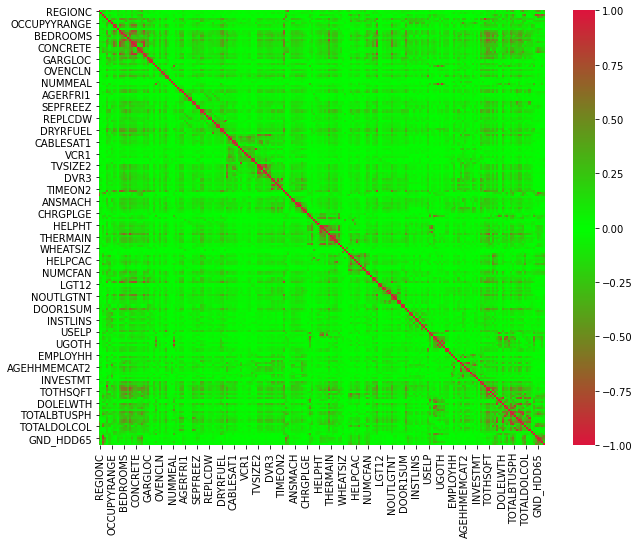

In [30]:
# Correlation matrix plot for the data set at this point
fig, ax = plt.subplots(figsize=(10,8))

cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'lime', 'crimson'])
ax = sns.heatmap(df.corr(), cmap=cmap, vmin=-1, vmax=1)
plt.show()

Although there seems to be some minor collinearity left in the data set, the results of "Feature Engineering" seem to be decent.

#### 3-2 Removing Outliers

The presence of outliers can significantly affect the performance of the created model. As a heuristic, an outlier of a column in a dataset is defined as a value that is more than `3` standard deviations from the mean of the column values.

I will now use this heuristic to remove outliers in the remaining columns of the data set.

The data set in its current state has two categorical features (`['UR', 'IECC_Climate_Pub']`).

Let's check the shape of the data set **before** removing outliers.

In [31]:
df.shape

(12083, 222)

##### 3-2-1 Method 1

In this method, I will use `z-scores` to remove outliers in the whole data set.

In [32]:
# Removing outliers using z-scores
categorical_features = ['UR', 'IECC_Climate_Pub'] # These are the two categorical columns in the data set
numeric_df = df.copy()
numeric_df.drop(columns = categorical_features, inplace=True)
len(numeric_df.columns)

# Using z-scores 
z_scores = stats.zscore(numeric_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_filtered = numeric_df[filtered_entries]

Let's check the shape of the data frame **after** removing outliers.

In [33]:
df_filtered.shape

(3027, 220)

Wow! This method removes too many rows which is too much of a loss of data. The reason is that in above method, all  the rows that include at least one outlier in a column are aggressively removed.

##### 3-2-2 Method 2

To avoid this issue, I should be less strict on removing the outliers and first see what percentage of each column is outliers. The following code does this.

In [34]:
# Returning the percentage of outliers in each column

# Defining 25th and 75th percentile
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

((((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum())/df.shape[0]) * 100 

ACOTHERS          0.000000
ADQINSUL          0.984855
AGECDRYER        19.697095
AGECENAC         19.423984
AGECWASH         18.852934
                   ...    
WINDOWS           3.732517
WORKPAY          23.322023
WSF               0.107589
WWACAGE          21.989572
YEARMADERANGE     0.000000
Length: 222, dtype: float64

**Note:** I want to see which columns have `< 1%` outliers. For these columns I would remove the outlier rows. For columns with `> 1%` outliers I would replace the outlier with the mean of the column. The stricter this assumption (limits greater than **1**) the more data will be lost. So I think this would be a safe assumption.

In [35]:
# Removing outliers using percentiles 
for col in df.columns:
    if col in ['UR', 'IECC_Climate_Pub']:
        continue
        
    Q1_col, Q3_col = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR_col = Q3_col - Q1_col
    lower, upper = Q1_col - IQR_col * 1.5, Q3_col + IQR_col * 1.5
    outliers = df[(df[col] < lower) | (df[col] > upper)] 
    if len(outliers) > 0:
        percentage = (outliers.shape[0] / df.shape[0]) * 100
        if percentage < 1:
            df.drop(index=outliers.index, inplace=True)
    else:
        df[col].where(((df[col] < lower) | (df[col] > upper)),df[col].mean())

Let's check the shape of the data frame **after** removing outliers.

In [36]:
df.shape

(11076, 222)

This method makes more sense and I will stick to it.

As mentioned above, since I am done with removing redundant columns at this point, I will add the target column `"KWH"` back in as below.

In [37]:
# Adding target: KWH column back to the data set
df = df.merge(KWH_df, left_index=True, right_index=True)
df.head()

,REGIONC,NWEIGHT,CDD30YR,Climate_Region_Pub,UR,KOWNRENT,YEARMADERANGE,OCCUPYYRANGE,NUMFLRS,NUMAPTS,...,TOTALDOLRFG,PERIODEL,SCALENG,IECC_Climate_Pub,CDD80,GND_HDD65,WSF,OA_LAT,DesignDBT1,KWH
0,2,2471.68,1271,4,U,1,7,8,-2,-2,...,108,1,-2,4A,56,4250,0.48,6,96,18466
1,4,8599.17,143,5,U,2,6,8,-2,-2,...,121,1,0,3C,26,2393,0.61,0,73,5148
2,1,8969.92,829,1,U,2,3,7,2,8,...,243,1,3,5A,49,5654,0.48,3,88,2218
3,2,18003.64,868,1,U,1,5,5,-2,-2,...,159,5,3,5A,0,4941,0.55,4,87,10015
4,1,5999.61,797,1,U,1,5,5,-2,-2,...,85,1,0,5A,0,5426,0.61,4,90,2869


In [38]:
# Sanity check
"KWH" in df.columns

True

I will now continue with this data set for the modeling.

### 4- Pre-processing

Let's split the data into train/test sets.

In [39]:
# Splitting the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,REGIONC,NWEIGHT,CDD30YR,Climate_Region_Pub,UR,KOWNRENT,YEARMADERANGE,OCCUPYYRANGE,NUMFLRS,NUMAPTS,...,TOTALDOLRFG,PERIODEL,SCALENG,IECC_Climate_Pub,CDD80,GND_HDD65,WSF,OA_LAT,DesignDBT1,KWH
10793,2,2711.43,1657,4,U,2,1,8,-2,-2,...,73,1,0,4A,77,4530,0.51,4,91,8619
4799,1,6814.27,698,1,U,1,2,7,-2,-2,...,238,1,3,5A,2,5450,0.59,4,85,7468
5863,3,7968.44,2423,2,U,2,5,8,2,8,...,170,5,-2,3B-4B,485,1254,0.52,2,101,9515
11651,1,6919.42,762,1,U,1,1,8,-2,-2,...,213,1,0,5A,23,5096,0.58,4,86,7216
1228,1,6919.42,737,1,U,1,5,5,-2,-2,...,150,1,0,5A,11,5082,0.60,5,85,10914


Below, I will divide the columns into different groups for pre-processing.

In [40]:
# Reidentifying the target and different features
target = "KWH"

binary_features = ["UR"]
categorical_features = ["IECC_Climate_Pub"]
numeric_features = list(
    set(train_df.columns) - set(categorical_features) - set(binary_features) - set([target])
)

Coming up next is splitting train/test sets into corresponding X and y sets.

In [41]:
# Splitting X and y for train_df and test_df
X_train, y_train = train_df.drop(columns=["KWH"]), train_df["KWH"]
X_test, y_test = test_df.drop(columns=["KWH"]), test_df["KWH"]

What I will do next is to define appropriate feature transformers.

In [42]:
# Defining feature transformers
numeric_transformer = make_pipeline(StandardScaler())

binary_transformer = make_pipeline(
    OneHotEncoder(drop="if_binary"),
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
)

# Defining the preprocessor (column transformer)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features)
)

### 5- Modeling

My strategy for the modeling is to first build a Dummy model as a sanity check and then to use a Linear Regression model (here `Ridge()`) as a starting point. I want to avoid vanilla `LinearRegression()` as it is less flexible compared to `Ridge()` and you would end up with huge coefficients in case there are any remaining collinear features in the data set. `Ridge()` also has the alpha hyperparameter which alows tuning of the model.

I will also consider `Gradient Boosting Model` (`GBM`) to compare with `Ridge`.

#### DummyRegressor

In [43]:
# Modeling with DummyRegressor() 
dummy_pipe = Pipeline(
        steps=[
            ("prepro", preprocessor),
            ("Ridge", DummyRegressor())
        ]
    )

scores = cross_validate(
    dummy_pipe,
    X_train,
    y_train,
    scoring='r2',
    return_train_score=True)

results_df = {} # A dictionary to store the results
df_dummy = pd.DataFrame(scores)
results_df["Dummy"] = df_dummy.mean()
pd.DataFrame(results_df).T

,fit_time,score_time,test_score,train_score
Dummy,0.068003,0.012399,-0.000368,0.0


Sanity check, **checked**. Typical of `DummyRegressor`.

**Note:** `test_score` here is actually `validation_score`.

#### Ridge

In [44]:
# Modeling with Ridge() with hyperparameter optimization
ridge_pipe = Pipeline(
        steps=[
            ("prepro", preprocessor),
            ("Ridge", Ridge())
        ]
    )
param_grid_ridge = {
        'Ridge__alpha': 10.0**np.arange(-5,5,1) # Range of alpha for hyperparameter optimization
    }
hyper_parameters_search_ridge = GridSearchCV(ridge_pipe, param_grid=param_grid_ridge, n_jobs=-1, scoring='r2')
hyper_parameters_search_ridge.fit(X_train, y_train)


scores = cross_validate(
    hyper_parameters_search_ridge.best_estimator_,
    X_train,
    y_train,
    scoring='r2',
    return_train_score=True)

df_ridge = pd.DataFrame(scores)
results_df["Ridge"] = df_ridge.mean()
pd.DataFrame(results_df).T

,fit_time,score_time,test_score,train_score
Dummy,0.068003,0.012399,-0.000368,0.000000
Ridge,1.414874,0.013206,0.977672,0.980592


The results sound great. Also, there is no sign of overfitting.

Let's see what we get with `GBM`.

#### GradientBoostingRegressor

In [45]:
# Modeling with GradientBoostingRegressor() with hyperparameter optimization
gb_pipe = Pipeline(
        steps=[
            ("prepro", preprocessor),
            ("GradientBoostingRegressor", GradientBoostingRegressor(random_state=123))
        ]
    )

param_grid_gb = {"GradientBoostingRegressor__n_estimators": [5, 10, 50, 100], # Range of n_estimators for hyperparameter optimization
                     "GradientBoostingRegressor__max_depth": [3, 5, 7]}       # Range of max_depth for hyperparameter optimization

hyper_parameters_search_gb = GridSearchCV(gb_pipe, param_grid=param_grid_gb, n_jobs=-1, scoring='r2')
hyper_parameters_search_gb.fit(X_train, y_train)


scores = cross_validate(
    hyper_parameters_search_gb.best_estimator_,
    X_train,
    y_train,
    scoring='r2',
    return_train_score=True)

df_gb = pd.DataFrame(scores)
results_df["Gradient Boosting"] = df_gb.mean()
pd.DataFrame(results_df).T

,fit_time,score_time,test_score,train_score
Dummy,0.068003,0.012399,-0.000368,0.000000
Ridge,1.414874,0.013206,0.977672,0.980592
Gradient Boosting,15.135172,0.019206,0.973396,0.994968


The results from `GradientBoostingRegressor()` sound great as well. Again no major overfitting. 

Based on the results obtained, there is a close tie between `Ridge()` and `GradientBoostingRegressor()` and I can go with any of them. However, I will be using the `Ridge()` model to make predictions. Below is the test score on the test set.

In [46]:
# Scoring the GBM on the test set
hyper_parameters_search_ridge.best_estimator_.fit(X_train, y_train)
print("Test score: ", round(hyper_parameters_search_ridge.best_estimator_.score(X_test, y_test), 6))

Test score:  0.979781


**This result is awesome.**

**Disclaimer:** There are several ways to improve the modeling such as looking into other regressors (+ hyperparameter optimization), building ensemble models, running feature selection, etc. which would require more time. However, I am already getting decent results with above models and there would be no need to spend more time on the modeling. 

### 6- Conclusions

First conducted in 1978, the Residential Energy Consumption Survey (RECS) is a national sample survey that collects energy-related data for housing units occupied as a primary residence and the households that live in them.

In its 2009 version, data were collected from **12,083** households selected at random using a complex multistage, area-probability sample design. The sample represents **113.6** million U.S. households, the Census Bureau’s statistical estimate for all occupied housing units in 2009 derived from their American Community Survey (ACS). More can be found [here](https://www.eia.gov/consumption/residential/data/2009/index.php?view=microdata).

I have leveraged this data set to build a model that predicts electrical energy consumption in `KWH` (kilowatt-hour).

The data set in its original format has **940** columns. Here is a view of the original data set.

In [47]:
# Original data set after Feature Engineering
original_df.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


I dedicated a significant amount of time spent on this report on **"Feature Engineering"** and more specifically on removing redundant columns. Here is a view of the modified data set.

In [48]:
# Modified data set after Feature Engineering
df.head()

,REGIONC,NWEIGHT,CDD30YR,Climate_Region_Pub,UR,KOWNRENT,YEARMADERANGE,OCCUPYYRANGE,NUMFLRS,NUMAPTS,...,TOTALDOLRFG,PERIODEL,SCALENG,IECC_Climate_Pub,CDD80,GND_HDD65,WSF,OA_LAT,DesignDBT1,KWH
0,2,2471.68,1271,4,U,1,7,8,-2,-2,...,108,1,-2,4A,56,4250,0.48,6,96,18466
1,4,8599.17,143,5,U,2,6,8,-2,-2,...,121,1,0,3C,26,2393,0.61,0,73,5148
2,1,8969.92,829,1,U,2,3,7,2,8,...,243,1,3,5A,49,5654,0.48,3,88,2218
3,2,18003.64,868,1,U,1,5,5,-2,-2,...,159,5,3,5A,0,4941,0.55,4,87,10015
4,1,5999.61,797,1,U,1,5,5,-2,-2,...,85,1,0,5A,0,5426,0.61,4,90,2869


For the modeling, I mainly made use of Linear `Ridge()` and `GradientBoostingRegressor()` to make models which enjoyed built-in hyperparameter optimization.

The results (**R2 scores** as the metric in this analysis) from both models were awesome. Below is the summary of models scores.

In [49]:
pd.DataFrame(results_df).T

,fit_time,score_time,test_score,train_score
Dummy,0.068003,0.012399,-0.000368,0.000000
Ridge,1.414874,0.013206,0.977672,0.980592
Gradient Boosting,15.135172,0.019206,0.973396,0.994968


So I picked `Ridge()` to make predictions on the test set which also had decent test scores. Below is the test score on the test set.

In [50]:
round(hyper_parameters_search_ridge.best_estimator_.score(X_test, y_test), 6)

0.979781

##### This model is ready for the wild.

-------------------------------------------------------------

#### This is the end of the script.